<a href="https://colab.research.google.com/github/kridtapon/Chaos-Compression-Spike-Strategy/blob/main/Chaos_Compression_Spike_Strategy.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
pip install vectorbt

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 527.6/527.6 kB 7.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 295.7/295.7 kB 6.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 119.7/119.7 kB 6.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 29.6 MB/s eta 0:00:00


In [2]:
pip install --upgrade yfinance

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 117.4/117.4 kB 6.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.4/7.4 MB 90.1 MB/s eta 0:00:00
  Attempting uninstall: yfinance
    Found existing installation: yfinance 0.2.57
    Uninstalling yfinance-0.2.57:
      Successfully uninstalled yfinance-0.2.57


In [6]:
import numpy as np
import pandas as pd
import yfinance as yf
import vectorbt as vbt

# Function to calculate TRIX
def calculate_trix(close, period=15):
    """
    Calculate TRIX: triple smoothed EMA.
    """
    ema1 = close.ewm(span=period, adjust=False).mean()
    ema2 = ema1.ewm(span=period, adjust=False).mean()
    ema3 = ema2.ewm(span=period, adjust=False).mean()
    trix = ema3.pct_change() * 100
    return trix

# Function to calculate DMI (includes +DI, -DI, ADX)
def calculate_dmi(df, period=14):
    """
    Calculate Directional Movement Index (DMI).
    """
    high = df['High']
    low = df['Low']
    close = df['Close']

    # Calculate directional movements
    plus_dm = high.diff()
    minus_dm = low.diff()

    # Apply conditions for positive and negative directional movements
    plus_dm = np.where((plus_dm > minus_dm) & (plus_dm > 0), plus_dm, 0.0)
    minus_dm = np.where((minus_dm > plus_dm) & (minus_dm > 0), minus_dm, 0.0)

    # Convert to pandas Series for alignment with DataFrame
    plus_dm = pd.Series(plus_dm, index=df.index)
    minus_dm = pd.Series(minus_dm, index=df.index)

    # Calculate True Range (TR) and Average True Range (ATR)
    tr = pd.concat([high - low, abs(high - close.shift()), abs(low - close.shift())], axis=1).max(axis=1)
    atr = tr.rolling(window=period, min_periods=1).mean()  # Handle NaN with min_periods=1

    # Calculate +DI and -DI
    plus_di = 100 * plus_dm.rolling(window=period, min_periods=1).sum() / atr
    minus_di = 100 * minus_dm.rolling(window=period, min_periods=1).sum() / atr

    # Calculate the DX (Directional Index)
    dx = (abs(plus_di - minus_di) / (plus_di + minus_di)) * 100
    adx = dx.rolling(window=period, min_periods=1).mean()  # ADX is smoothed DX

    return plus_di, minus_di, adx

# Define stock and download data
symbol = 'TPL'
start_date = '2019-01-01'
end_date = '2025-01-01'

df = yf.download(symbol, start=start_date, end=end_date, multi_level_index=False)

# Calculate indicators
df['Trix'] = calculate_trix(df['Close'], period=15)
df['+DI'], df['-DI'], df['ADX'] = calculate_dmi(df, period=14)

# Strategy logic
df['Entry'] = (df['Trix'] > 0) & (df['+DI'] > df['-DI']) & (df['ADX'] > 20)
df['Exit'] = (df['Trix'] < 0) & (df['-DI'] > df['+DI']) & (df['ADX'] > 20)

# Filter for test period
df = df[(df.index.year >= 2020) & (df.index.year <= 2025)]

# Shift signals for execution on next bar
entries = df['Entry'].shift(1).fillna(False).astype(bool).to_numpy()
exits = df['Exit'].shift(1).fillna(False).astype(bool).to_numpy()

# Create portfolio
portfolio = vbt.Portfolio.from_signals(
    close=df['Open'],
    entries=entries,
    exits=exits,
    init_cash=100_000,
    fees=0.001,
    slippage=0.002,
    freq='D'
)

# Print stats and show plot
print(portfolio.stats())
portfolio.plot().show()


[*********************100%***********************]  1 of 1 completed
<ipython-input-6-5f82e743b4f5>:71: FutureWarning:

Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`

<ipython-input-6-5f82e743b4f5>:72: FutureWarning:

Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`



Start                         2020-01-02 00:00:00
End                           2024-12-31 00:00:00
Period                         1258 days 00:00:00
Start Value                              100000.0
End Value                           904425.739729
Total Return [%]                        804.42574
Benchmark Return [%]                   367.270434
Max Gross Exposure [%]                      100.0
Total Fees Paid                       3855.167156
Max Drawdown [%]                        37.412667
Max Drawdown Duration           266 days 00:00:00
Total Trades                                    6
Total Closed Trades                             6
Total Open Trades                               0
Open Trade PnL                                0.0
Win Rate [%]                            66.666667
Best Trade [%]                         185.616853
Worst Trade [%]                        -17.389625
Avg Winning Trade [%]                   93.053894
Avg Losing Trade [%]                   -10.819659


[*********************100%***********************]  1 of 1 completed


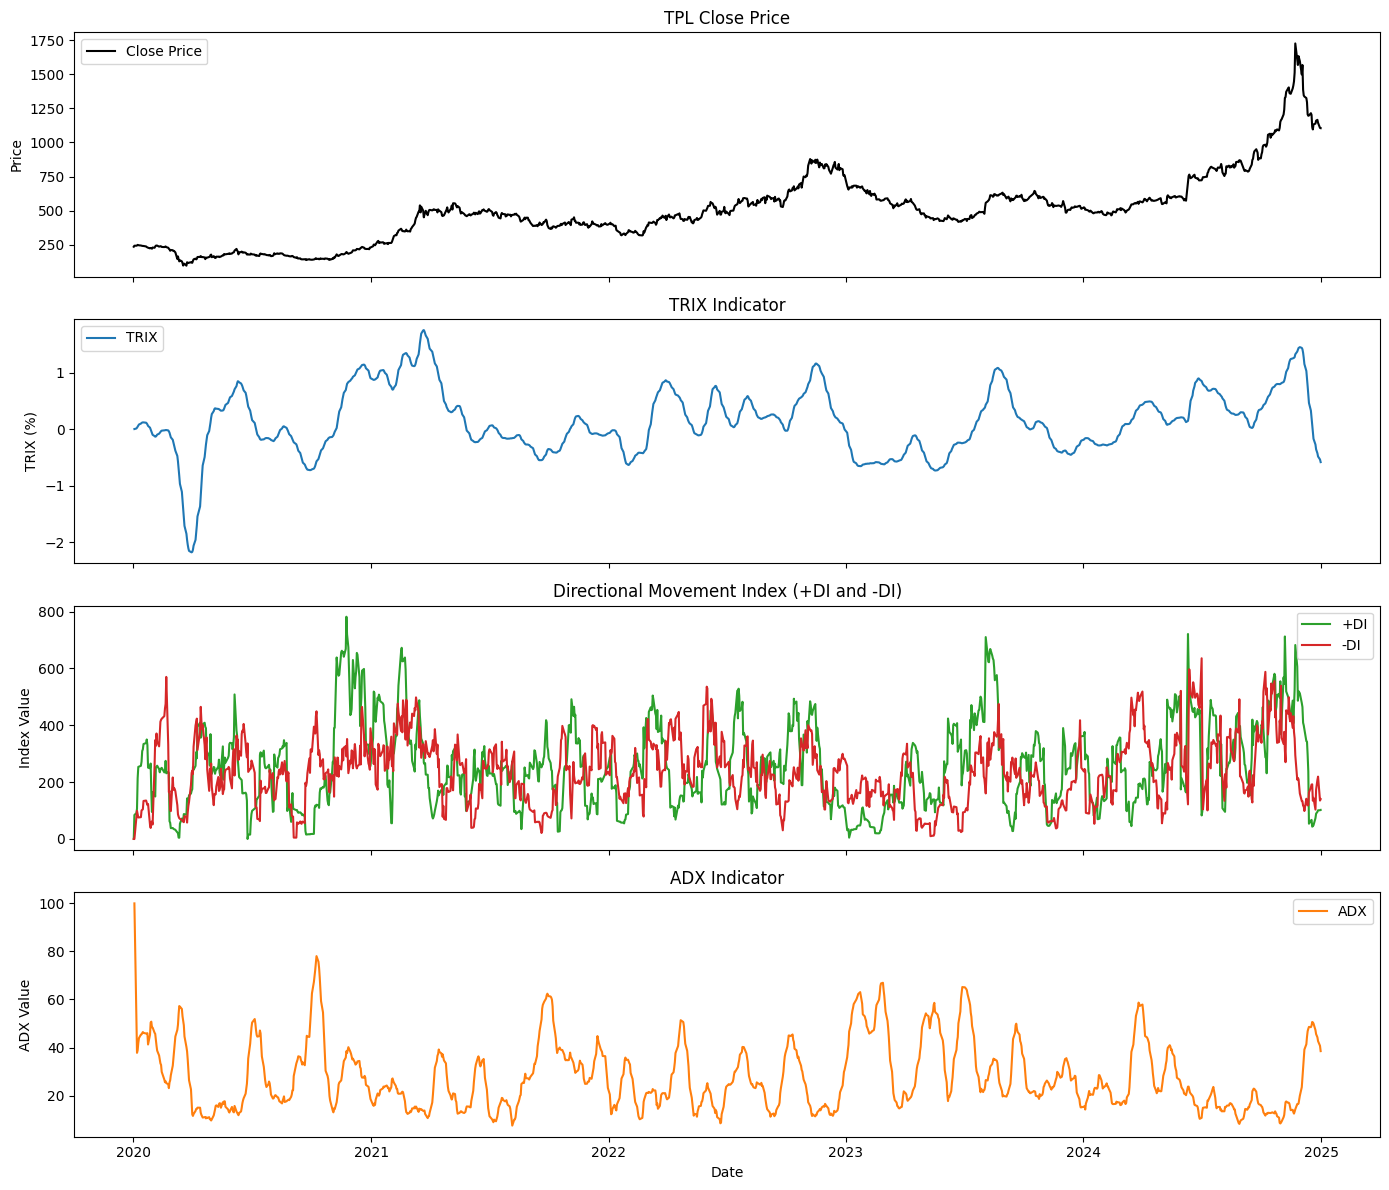

In [7]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import yfinance as yf

# Function to calculate TRIX
def calculate_trix(close, period=15):
    """
    Calculate TRIX: triple smoothed EMA.
    """
    ema1 = close.ewm(span=period, adjust=False).mean()
    ema2 = ema1.ewm(span=period, adjust=False).mean()
    ema3 = ema2.ewm(span=period, adjust=False).mean()
    trix = ema3.pct_change() * 100
    return trix

# Function to calculate DMI (includes +DI, -DI, ADX)
def calculate_dmi(df, period=14):
    """
    Calculate Directional Movement Index (DMI).
    """
    high = df['High']
    low = df['Low']
    close = df['Close']

    # Calculate directional movements
    plus_dm = high.diff()
    minus_dm = low.diff()

    # Apply conditions for positive and negative directional movements
    plus_dm = np.where((plus_dm > minus_dm) & (plus_dm > 0), plus_dm, 0.0)
    minus_dm = np.where((minus_dm > plus_dm) & (minus_dm > 0), minus_dm, 0.0)

    # Convert to pandas Series for alignment with DataFrame
    plus_dm = pd.Series(plus_dm, index=df.index)
    minus_dm = pd.Series(minus_dm, index=df.index)

    # Calculate True Range (TR) and Average True Range (ATR)
    tr = pd.concat([high - low, abs(high - close.shift()), abs(low - close.shift())], axis=1).max(axis=1)
    atr = tr.rolling(window=period, min_periods=1).mean()  # Handle NaN with min_periods=1

    # Calculate +DI and -DI
    plus_di = 100 * plus_dm.rolling(window=period, min_periods=1).sum() / atr
    minus_di = 100 * minus_dm.rolling(window=period, min_periods=1).sum() / atr

    # Calculate the DX (Directional Index)
    dx = (abs(plus_di - minus_di) / (plus_di + minus_di)) * 100
    adx = dx.rolling(window=period, min_periods=1).mean()  # ADX is smoothed DX

    return plus_di, minus_di, adx

# Define stock and download data
symbol = 'TPL'
start_date = '2020-01-01'
end_date = '2025-01-01'

df = yf.download(symbol, start=start_date, end=end_date, multi_level_index=False)

# Calculate TRIX and DMI
df['TRIX'] = calculate_trix(df['Close'])
plus_di, minus_di, adx = calculate_dmi(df)

df['+DI'] = plus_di
df['-DI'] = minus_di
df['ADX'] = adx

# Create a figure with 4 vertically stacked subplots (shared x-axis)
fig, (ax0, ax1, ax2, ax3) = plt.subplots(4, 1, figsize=(14, 12), sharex=True)

# Plot Close Price
ax0.plot(df.index, df['Close'], label='Close Price', color='black')
ax0.set_title(f'{symbol} Close Price')
ax0.set_ylabel('Price')
ax0.legend()

# Plot TRIX
ax1.plot(df.index, df['TRIX'], label='TRIX', color='tab:blue')
ax1.set_title('TRIX Indicator')
ax1.set_ylabel('TRIX (%)')
ax1.legend()

# Plot DMI (+DI, -DI)
ax2.plot(df.index, df['+DI'], label='+DI', color='tab:green')
ax2.plot(df.index, df['-DI'], label='-DI', color='tab:red')
ax2.set_title('Directional Movement Index (+DI and -DI)')
ax2.set_ylabel('Index Value')
ax2.legend()

# Plot ADX
ax3.plot(df.index, df['ADX'], label='ADX', color='tab:orange')
ax3.set_title('ADX Indicator')
ax3.set_xlabel('Date')
ax3.set_ylabel('ADX Value')
ax3.legend()

# Improve layout
plt.tight_layout()
plt.show()